In [1]:
import pandas as pd
import seaborn as sns
import os

In [17]:
dfs = []

bench_dir = "bench"

for cmd in os.listdir(bench_dir):
    for store_config in os.listdir(os.path.join(bench_dir, cmd)):
        parts = store_config.split("-")
        store = parts[0]
        tls = parts[1] == "tls"
        enclave = parts[2]
        
        file = os.path.join(bench_dir, cmd, store_config, "timings.csv")
        if not os.path.exists(file):
            continue
        df = pd.read_csv(file)
        start = df['start_micros'].min()
        df['start_micros'] -= start
        df['start_ms'] = df['start_micros'] / 1000
        df.drop(['start_micros'], axis=1, inplace=True)
        df['end_micros'] -= start
        df['end_ms'] = df['end_micros'] / 1000
        df.drop(['end_micros'], axis=1, inplace=True)
        df['latency_ms'] = (df['end_ms'] - df['start_ms'])
        df["cmd"] = cmd
        df["store"] = store
        df["tls"] = tls
        df["enclave"] = enclave
        dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)
all_data.head()

,start_ms,end_ms,latency_ms,cmd,store,tls,enclave
0,0.000,48.817,48.817,txn-put,ccfkvs,True,virtual
1,48.843,50.397,1.554,txn-put,ccfkvs,True,virtual
2,50.400,51.863,1.463,txn-put,ccfkvs,True,virtual
3,51.866,53.298,1.432,txn-put,ccfkvs,True,virtual
4,53.300,102.521,49.221,txn-put,ccfkvs,True,virtual


In [18]:
all_data[all_data.latency_ms < 0]

,start_ms,end_ms,latency_ms,cmd,store,tls,enclave
65062,344.557,336.633,-7.924,txn-mixed_txn-mixed-key,etcd,True,virtual
65544,1307.623,1298.177,-9.446,txn-mixed_txn-mixed-key,etcd,True,virtual
65664,1548.343,1528.059,-20.284,txn-mixed_txn-mixed-key,etcd,True,virtual
70120,274.855,262.435,-12.420,txn-mixed_txn-mixed-key,etcd,False,virtual
70602,1128.478,1118.966,-9.512,txn-mixed_txn-mixed-key,etcd,False,virtual
70722,1343.541,1321.084,-22.457,txn-mixed_txn-mixed-key,etcd,False,virtual
95883,345.988,344.320,-1.668,range_range-key,etcd,False,virtual


In [19]:
all_data = all_data[all_data.latency_ms >= 0]

In [20]:
all_data["store_tls"] = all_data["store"] + "_" + all_data["tls"].map(lambda t: "tls" if t else "plain")

In [24]:
all_data["start_s"] = all_data["start_ms"] / 1000

In [25]:
all_data

,start_ms,end_ms,latency_ms,cmd,store,tls,enclave,store_tls,start_s
0,0.000,48.817,48.817,txn-put,ccfkvs,True,virtual,ccfkvs_tls,0.000000
1,48.843,50.397,1.554,txn-put,ccfkvs,True,virtual,ccfkvs_tls,0.048843
2,50.400,51.863,1.463,txn-put,ccfkvs,True,virtual,ccfkvs_tls,0.050400
3,51.866,53.298,1.432,txn-put,ccfkvs,True,virtual,ccfkvs_tls,0.051866
4,53.300,102.521,49.221,txn-put,ccfkvs,True,virtual,ccfkvs_tls,0.053300
...,...,...,...,...,...,...,...,...,...
105053,3590.910,3591.388,0.478,range_range-key,etcd,False,virtual,etcd_plain,3.590910
105054,3591.389,3591.801,0.412,range_range-key,etcd,False,virtual,etcd_plain,3.591389
105055,3591.804,3592.204,0.400,range_range-key,etcd,False,virtual,etcd_plain,3.591804
105056,3592.205,3592.480,0.275,range_range-key,etcd,False,virtual,etcd_plain,3.592205


In [22]:
# make the plots dir
os.makedirs("plots", exist_ok = True)

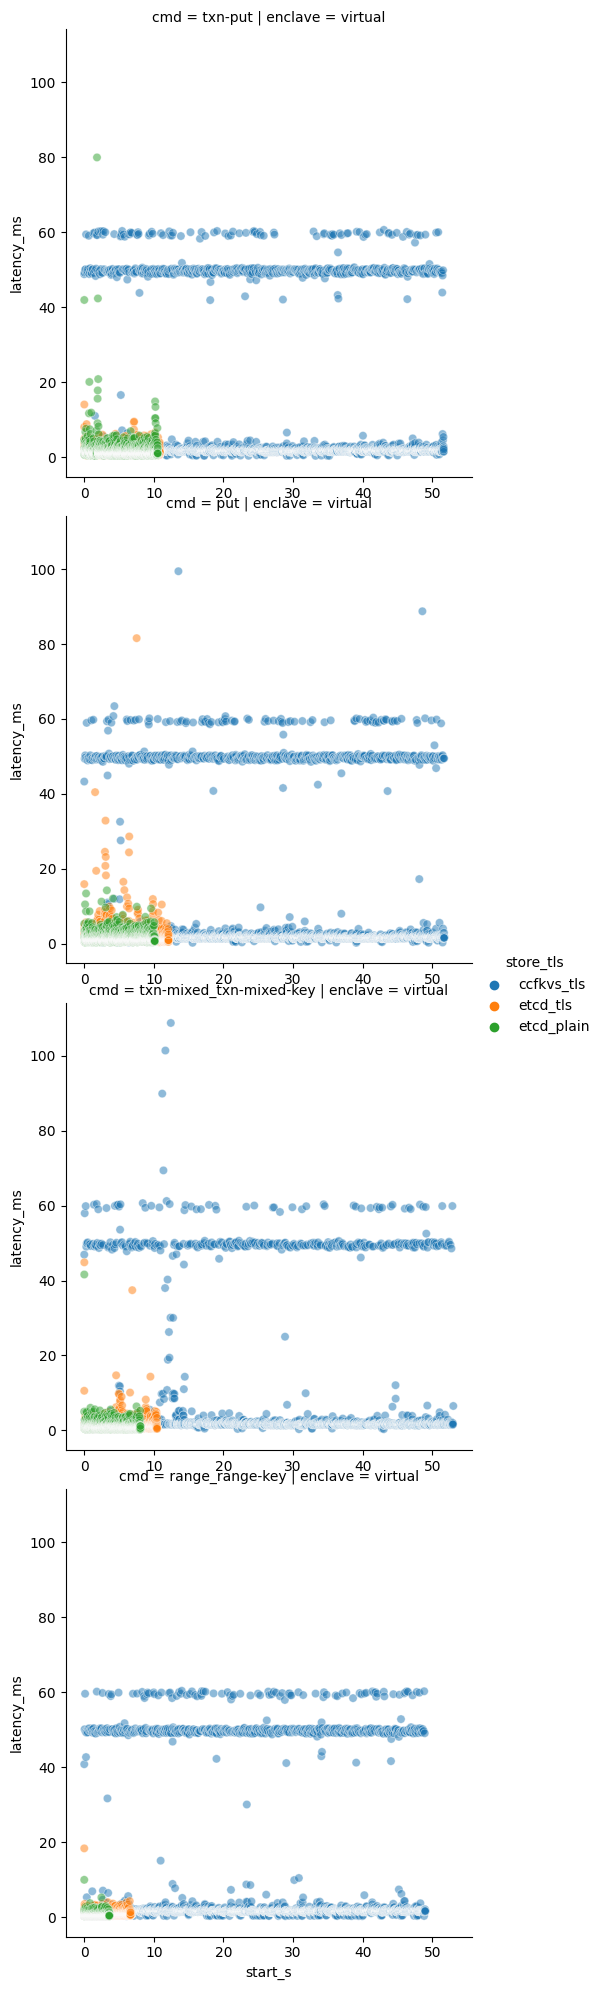

In [26]:
p = sns.relplot(kind="scatter", data=all_data, x="start_s", y="latency_ms", row="cmd", col="enclave", hue="store_tls", alpha=0.5)

# add tick labels to each x axis
for ax in p.axes.flatten():
    ax.tick_params(labelbottom=True)

p.savefig("plots/scatter.svg")

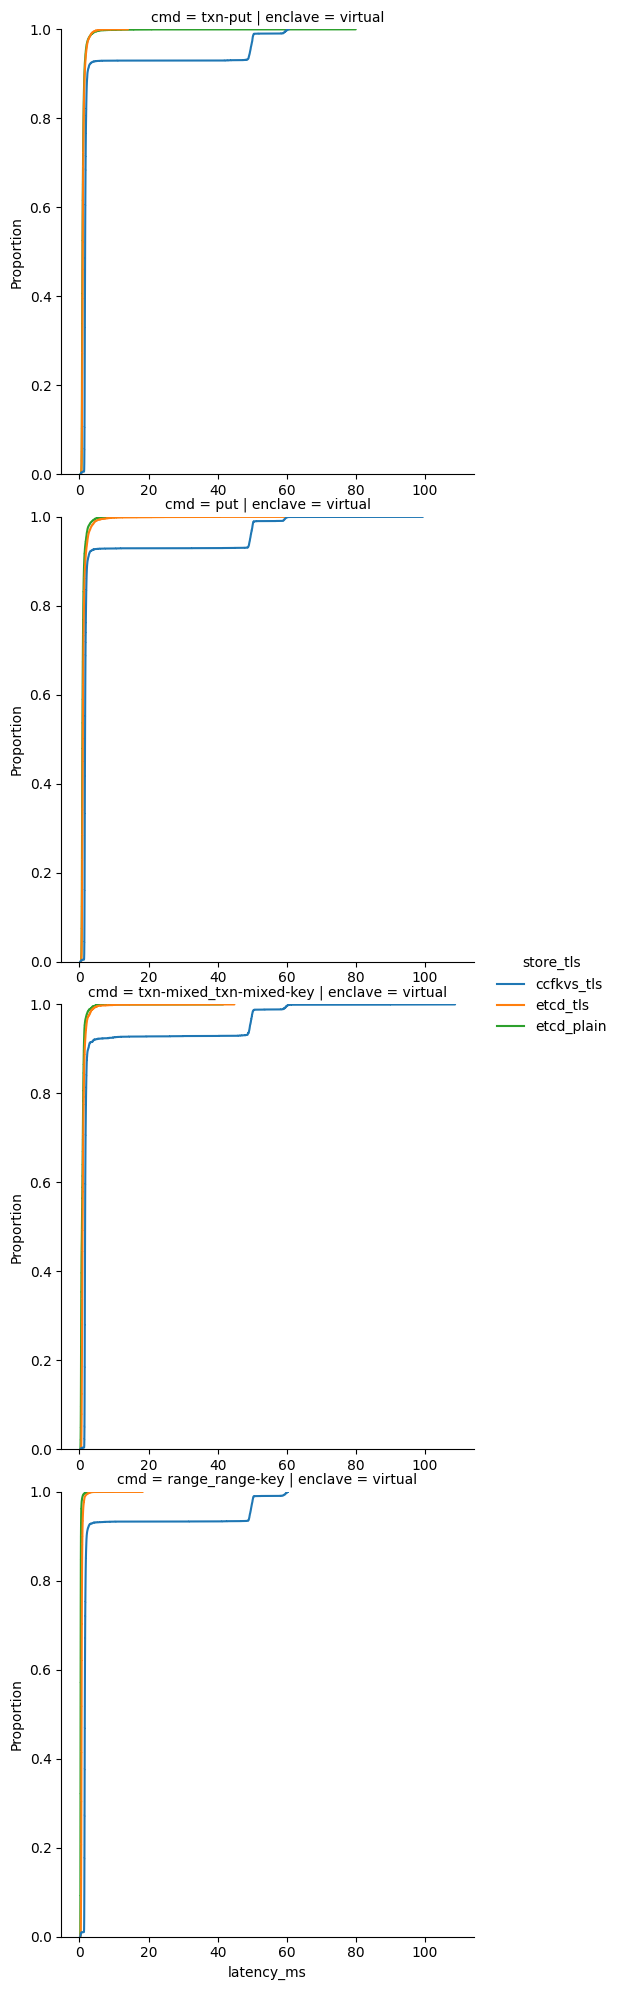

In [27]:
p = sns.displot(kind="ecdf", data=all_data, x="latency_ms", row="cmd", col="enclave", hue="store_tls")

# add tick labels to each x axis
for ax in p.axes.flatten():
    ax.tick_params(labelbottom=True)

p.savefig("plots/ecdf.svg")